# UB DataScience: Complex networks
### David Solans & Gerard Martinez

In [1]:

import networkx as nx
import matplotlib.pyplot as plt
from multiprocessing import Pool
import itertools
from networkx.algorithms import community
import collections

%matplotlib inline

## Exploratory Data Analysis¶

In [2]:
G = nx.read_edgelist("barcelona_transport.edgelist", create_using = nx.Graph(), nodetype = int)

In [3]:
#Quick snapshot of the Network
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 2497
Number of edges: 3296
Average degree:   2.6400


In [4]:
nodes = list(G.nodes())

In [5]:
def plotNetwork(G, node_categories, colormap="jet", pos=None):
    plt.axis("off")
    if pos == None:
        pos = spring_pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos = pos, cmap = plt.get_cmap(colormap), node_color = node_categories, node_size = 35, with_labels = False)

In [6]:
#Create network layout for visualizations
spring_pos = nx.spring_layout(G)

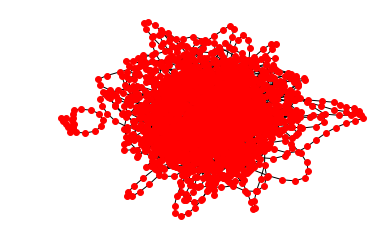

In [7]:
plt.axis("off")
nx.draw_networkx(G, pos = spring_pos, with_labels = False, node_size = 35)

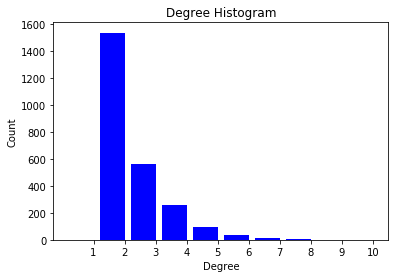

In [8]:
# Nodes degree histogram
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
plt.show()

In [9]:
# Degree per node
nodes_degrees = [0]*len(nodes)
for idx, n in enumerate(nodes):
    nodes_degrees [idx] = G.degree(n)

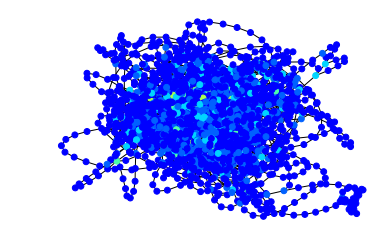

In [10]:
plotNetwork(G, nodes_degrees)

In [11]:
# Average separation of nodes
node_distances = []
sp = nx.all_pairs_shortest_path_length(G)
print(next(sp))
"""
for x in nodes:
    for y in nodes:
        if(x != y):
            node_distances = sp[x][y]
            
print("Average distance between nodes: ", mean(node_distances))
"""

(91, {91: 0, 26: 1, 3225: 1, 2968: 1, 334: 1, 41: 2, 2585: 2, 24: 2, 572: 2, 1434: 2, 472: 2, 916: 2, 2189: 2, 581: 2, 33: 3, 524: 3, 483: 3, 1381: 3, 231: 3, 21: 3, 107: 3, 12: 3, 25: 3, 962: 3, 889: 3, 2966: 3, 1611: 3, 2970: 3, 917: 3, 2187: 3, 1613: 3, 140: 4, 1763: 4, 682: 4, 520: 4, 1098: 4, 481: 4, 237: 4, 1377: 4, 2696: 4, 2333: 4, 2728: 4, 756: 4, 556: 4, 458: 4, 547: 4, 548: 4, 766: 4, 2541: 4, 2992: 4, 136: 4, 16: 4, 588: 4, 968: 4, 18: 4, 20: 4, 124: 4, 141: 4, 1900: 4, 888: 4, 565: 4, 507: 4, 540: 4, 2547: 4, 92: 4, 1612: 4, 185: 4, 81: 4, 1553: 4, 2522: 4, 1617: 4, 163: 4, 2131: 4, 101: 5, 1004: 5, 209: 5, 2069: 5, 1286: 5, 34: 5, 1628: 5, 700: 5, 512: 5, 65: 5, 928: 5, 1088: 5, 3223: 5, 516: 5, 480: 5, 765: 5, 291: 5, 110: 5, 3267: 5, 3287: 5, 627: 5, 1956: 5, 1440: 5, 232: 5, 755: 5, 3280: 5, 3233: 5, 1886: 5, 3232: 5, 2259: 5, 310: 5, 712: 5, 296: 5, 335: 5, 2586: 5, 250: 5, 3219: 5, 293: 5, 39: 5, 1554: 5, 1546: 5, 814: 5, 1172: 5, 769: 5, 1453: 5, 1023: 5, 967: 5, 26

'\nfor x in nodes:\n    for y in nodes:\n        if(x != y):\n            node_distances = sp[x][y]\n            \nprint("Average distance between nodes: ", mean(node_distances))\n'

## Parallel Betweenness Centrality

In [12]:
def partitions(nodes, n):
    "Partitions the nodes into n subsets"
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter,n))
        if not partition:
            return
        yield partition

In [13]:
def btwn_pool(G_tuple):
    return nx.betweenness_centrality_source(*G_tuple)

In [14]:
def between_parallel(G, processes = None):
    p = Pool(processes=processes)
    part_generator = 4*len(p._pool)
    node_partitions = list(partitions(G.nodes(), int(len(G)/part_generator)))
    num_partitions = len(node_partitions)
 
    bet_map = p.map(btwn_pool,
                        zip([G]*num_partitions,
                        [True]*num_partitions,
                        [None]*num_partitions,
                        node_partitions))
 
    bt_c = bet_map[0]
    for bt in bet_map[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

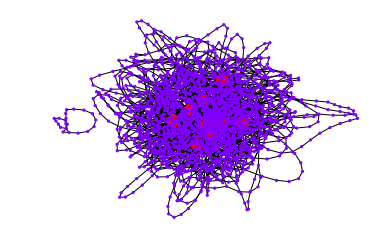

In [17]:
bt = between_parallel(G)
top = 10

max_nodes =  sorted(bt.items(), key = lambda v: -v[1])[:top]
bt_values = [5]*len(nodes)
bt_colors = [0]*len(nodes)
for max_key, max_val in max_nodes:
    bt_values[max_key] = 150
    bt_colors[max_key] = 2
 
plt.axis("off")
nx.draw_networkx(G, pos = spring_pos, cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False)

## Community Detection

In [18]:
communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
parts = sorted(map(sorted, next_level_communities))

In [19]:
node_communities = [0]*len(nodes)
for idx,c in enumerate(parts):
    for n in c:
        node_communities[nodes.index(n)] = idx
     

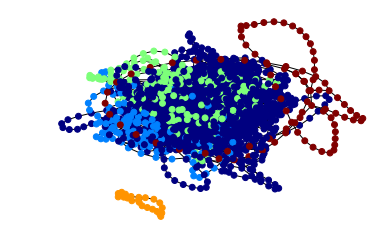

In [20]:
plotNetwork(G,node_communities)

In [21]:
help(community)

Help on package networkx.algorithms.community in networkx.algorithms:

NAME
    networkx.algorithms.community - Functions for computing and measuring community structure.

DESCRIPTION
    The functions in this class are not imported into the top-level
    :mod:`networkx` namespace. You can access these functions by importing
    the :mod:`networkx.algorithms.community` module, then accessing the
    functions as attributes of ``community``. For example::
    
        >>> import networkx as nx
        >>> from networkx.algorithms import community
        >>> G = nx.barbell_graph(5, 1)
        >>> communities_generator = community.girvan_newman(G)
        >>> top_level_communities = next(communities_generator)
        >>> next_level_communities = next(communities_generator)
        >>> sorted(map(sorted, next_level_communities))
        [[0, 1, 2, 3, 4], [5], [6, 7, 8, 9, 10]]

PACKAGE CONTENTS
    asyn_fluidc
    centrality
    community_generators
    community_utils
    kclique
    ke